# Generate model inputs

## This will set up the forcing for Abernathey Style Forcing

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import netCDF4
import sys
import math
from pylab import *
from IPython.display import display, Math, Latex
from numba import jit
import glob
%matplotlib inline
# Use writeFile to write files in the correct format!
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from Writebin import *
import SG
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils

When writing in python it is very important to note reverse dimensions!!
MITgcm assumes column major order (as does matlab) Python, uses row major order.
Mosty it's fine just to write straight to binary, but to absolutely specific of the format for MITgcm the WriteFile fuction (taken from the MITgcm csv gendata.py):

## Decide parameters:

In [5]:
Topo = "flat"  # Please Choose ridge, slope or flat
Wind = "Standard"  # Sine bell 0.2N/m$^2$
Heat = "nonetQ"  # Please Choose Abernathey or nonetQ
BC = "Sponge"  # Please Choose Sponge or Diffusion
Name = "My_restoring_90"  # Give Experiment Name
N = 1e3 # Set stratification
deltaT0 = 8 # top to bottom temp diff
N0 = 1000 # Natural stratification

In [6]:
# Adjust accordingly
Res = 5000
Ly = 2000e3
Lx = 1000e3 #Full domain = 4000km otherwise 1000km
H = 3000.0
nz = 30 # Diffusion = 24 level, Sponge= 30 levels

In [7]:
x = ( os.path.expanduser('~')+"/MITgcm/"+Name+"/input/")
if not os.path.exists(x):
       os.makedirs(x) 
os.chdir(x)

## Set up grid:

In [8]:
#Dimensions
nx = int(np.round(Lx/Res))
ny = int(np.round(Ly/Res))
dx = np.ones(nx)*Res
dy = np.ones(ny)*Res
#Write binary output
writeFile('delY',dy)
writeFile('delX',dx)
# Create c-grid with grid points in dead center
x = (np.cumsum(dx)-dx/2)-Lx/2
y = (np.cumsum(dy)-dy/2)-Ly/2
[Y, X] = np.meshgrid(y, x) 

## Now Create topography:

Start with flat, then add slope and ridges

In [9]:
h= -H*np.ones((nx,ny)) # Flat bottom
if Topo == "ridge":#2500 and 2000 for full depth
        h= h+((2500 + 300*np.sin(10*pi*Y/Ly) + 400*np.sin(8*pi*Y/Ly)
               + 300*sin(25*pi*Y/Ly) )*(1/np.cosh(((X)-0.2*Y+3e5)/1.2e5)))
        h= h+((2000 + 600*np.sin(11*pi*Y/Ly) + 300*np.sin(7*pi*Y/Ly)+
               500*sin(21*pi*Y/Ly) )*(1/np.cosh(((X)+0.1*Y+1.5e6)/1.2e5)))
if Topo == "slope" or Topo=="ridge":
    for i in range(int(nx)):
        slope= np.transpose(H*(np.divide((Y[i,0:round(0.2*ny)]
                                          -Y[i,0]),(Y[i,0]-Y[i,round(0.2*ny)]))))
        h2 = h[:,0:round(0.2*ny)]
        h[:,0:round(0.2*ny)]=np.maximum(slope,h2)
# Close both ends
h[:,0] = 0
h[:,-1] = 0
# Write to binary
writeFile('topog',np.transpose(h))

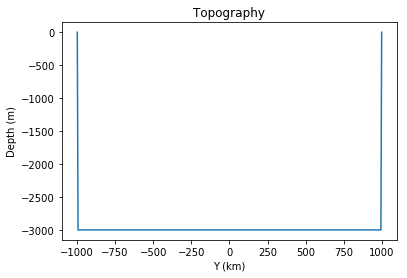

In [10]:
fig1 = plt.figure()
if Topo == "flat" or Topo == "slope":
    plt.plot(y/1000,h[nx/2,:])
    plt.title('Topography')
    plt.ylabel('Depth (m)')
    plt.xlabel('Y (km)')
if Topo == 'ridge':
    # plt.contourf(x/1000,y/1000,np.transpose(h),30)
    plt.contourf(np.transpose(h))
    cb = plt.colorbar()
    plt.title('Topography')
    plt.ylabel('Y (km)')
    plt.xlabel('X (km)')
    cb.set_label('Depth (m)')
# netcdf check
f = netCDF4.Dataset('topog.nc','w')
f.createDimension('X',nx)
f.createDimension('Y',ny)
h2=f.createVariable('h','float',('X','Y'))
h2[:] = h
f.close()


## Windstress

Plus the Windress with $\tau_o$ set to $0.2Nm^-2$

$\tau_s(y)=\tau_0 sin(\frac{\pi y}{Ly})$

In [11]:
tau=0.2*((np.sin((Y+Ly/2)*(pi/Ly)))) #Y is centred at 0 so put that back!
if BC=='Diffusion':
    Taunew = tau + 2e-3 * (np.random.random((nx,ny)) - 0.5)
    tau=Taunew
# Write to binary
writeFile('Wind',np.transpose(tau))
# netcdf check
f = netCDF4.Dataset('Wind.nc','w')
f.createDimension('Xp1',nx+1)
f.createDimension('Y',ny)
tau3=np.zeros((ny,nx+1))
tau3[:,1:]=np.transpose(tau)
tau2=f.createVariable('tau','double',('Xp1','Y'))
tau2[:]=np.transpose(tau3)
f.close()

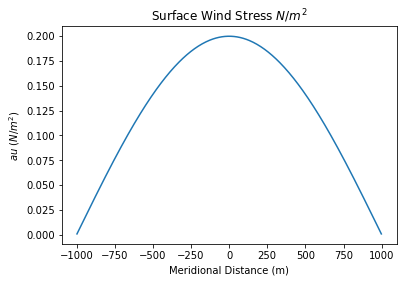

In [12]:
plt.plot(y/1000,tau[100,:])
plt.title('Surface Wind Stress $N/m^2$')
plt.ylabel('$\tau$ ($N/m^2$)')
plt.xlabel('Meridional Distance (m)')

## Generate Sponge

In [13]:
# Parameters
deltaT = deltaT0#-((N-N0)/N0)
Tref = np.zeros(nz)
# Create depth array:
# Tanh - normal
zp = np.linspace(1,0,31)
zp = H+H*1.0153*(tanh(-0.9*pi*zp))
zp = zp - zp[0]-(zp[1]-zp[0])
zp = np.round(zp,2)
dz = zp[0:-1] - zp[1::]
dz[-3::] = dz[-3]
zp[-1] = H
zp[1::] = np.cumsum(np.round(dz))
zp[0] = 0.5*zp[0]
writeFile('delZ',-dz)
# Z center points
z = zeros((nz))
z[1::] = (zp[1:-1]+zp[2::])/2
z[0]= zp[0]/2



In [14]:
print  ",".join(map(str,-dz))

4.39,5.29,6.38,7.68,9.25,11.13,13.38,16.08,19.31,23.14,27.7,33.11,39.49,46.98,55.73,65.88,77.56,90.87,105.88,122.55,140.76,160.29,180.72,201.49,221.85,240.96,257.83,271.54,271.54,271.54


\begin{equation}
T^*(z)=\Delta T \frac{(e^{z/N}-e^{-H/N})}{1-e^{-H/N}} + \left(\frac{N-N_0}{N_0}\right),
\end{equation} 

N max = H 

In [15]:
Tref = deltaT*(exp(z/N)-exp(-H/N))/(1-exp(-H/N))+2*((N-N0)/N0)
if N >= H:
    deltaT = 8 -((H-N0)/N0)
    Tref = deltaT*(exp(z/N)-exp(-H/N))/(1-exp(-H/N))+1+((H-N0)/N0)

max:  7.9907650344 
 min:  0.0605848438775


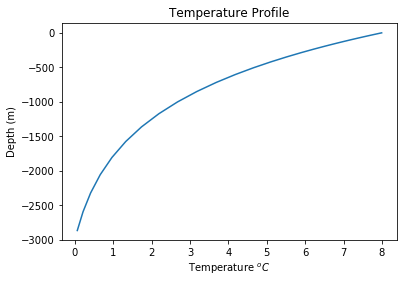

In [16]:
plt.plot(Tref,z)
print 'max: ', np.max(Tref), '\n min: ', np.min(Tref)
#plt.gca().invert_yaxis()
plt.title('Temperature Profile')
plt.ylabel('Depth (m)')
plt.xlabel('Temperature $^oC$')

In [17]:
#Make a 3D array of it
T=np.ones((nz,ny,nx))
Temp_field=np.zeros(np.shape(T))
for i in range(int(nx)):
    for j in range(int(ny)):
        Temp_field[:,j,i]=np.multiply(Tref,T[:,j,i])

In [18]:
Tnew = transpose(tile(Temp_field.mean(axis=2),(nx,1,1)),[1,2,0])
Tnew[:,-1] = Tnew[:,-2]
#Maybe add more 
if BC=='Diffusion':
    Tnew = Tnew + 2e-3 * (np.random.random((nz,ny,nx)) - 0.5)
else:
    Tnew = Tnew + 1e-3 * (np.random.random((nz,ny,nx)) - 0.5)

## Surface restoring ##

\begin{equation}
T_{s} = T_{ref} - \frac{Q}{\rho C_p \lambda \Delta z}
\end{equation}

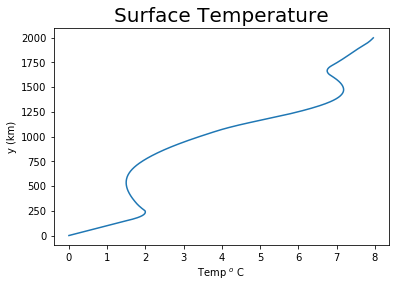

In [24]:
x = '/noc/msm/scratch/students/hb1g13/Mobilis'
fname = x+'/3daynokpp/'
c = utils.ChannelSetup(output_dir=str(fname))
Tavlat = c.get_zonal_avg('Tav.nc','THETA')
Tref = Tavlat[0,:]
Tref[-1] = Tref[-2]
Tref[0] = 0
Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
rho = 1030.0
Cp = 3985.0
lamba = 1.0/(90*24*60*60)
dz = c.dzf[0]
Ts = Tref - Q/(rho*Cp*lamba*dz)
#Ts[-1] = Ts[-2] 
Ts[0:40] = np.arange(0.0,2.,0.05)
Ts = SG.savitzky_golay(Ts,21,1) # Smooth just a little!
plt.plot(Ts,c.yc/1000)
plt.title('Surface Temperature',fontsize=20)
plt.ylabel('y (km)')
plt.xlabel('Temp $^o$ C')
Tsxy = np.tile(Ts,(nx,1))
Temp_field[0,:,:] = Tsxy.T

In [25]:
# Write to binary
writeFile('T_Sponge',Temp_field)
writeFile('T.init',Tnew)
# netcdf check
f = netCDF4.Dataset('TSponge.nc','w')
f.createDimension('X',nx)
f.createDimension('Y',ny)
f.createDimension('Z',nz)
Temp=f.createVariable('Temp','double',('Z','Y','X'))
Temp[:]=Temp_field
f.close()

In [26]:
#Make 3D mask
#Must vary between 0 (no Relaxation) and 1 (full relaxtion)
#I have gone for a parabolic decay in x and linear decay in z (from playing around)
msk = np.zeros(np.shape(T))
for k in range(0,len(z)):
    for i in range(nx):  
        msk[k,ny-20:ny,i]=((np.divide((Y[i,ny-21:ny-1]-Y[i,ny-21]),(Y[i,ny-1]-Y[i,ny-21]))))
msk[0,:,:] = 1
# Write to binary
writeFile('T.msk',msk)
# netcdf check
f = netCDF4.Dataset('Mask.nc','w')
f.createDimension('X',nx)
f.createDimension('Y',ny)
f.createDimension('Z',nz)
Mask=f.createVariable('Mask','double',('Z','Y','X'))
Mask[:]=(msk)
f.close()

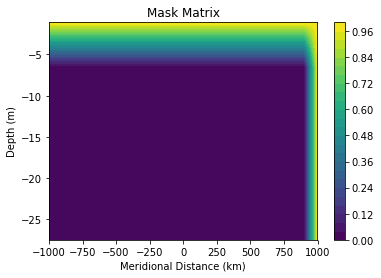

In [27]:
plt.contourf(y/1000,z[0:5],msk[0:5,:,100],24,cm=cm.Spectral)
cbar = plt.colorbar()
plt.gca()#.invert_yaxis()
plt.title('Mask Matrix')
plt.ylabel('Depth (m)')
plt.xlabel('Meridional Distance (km)')